# DOG BREED RECOGNITION

<br>

@author: Juarez Monteiro

## Este Notebook compreende a Segunda e a Terceira parte do desafio proposto.

---

## Segunda Parte

Agora crie um sistema para lidar com raças não vistas em tempo de treinamento, ou seja, raças diferentes das 100 utilizadas inicialmente. Como no sistema anterior, ele deve ser treinado utilizando-se as imagens da pasta **train**. 


Para permitir o reconhecimento de novas raças, dentro da pasta **recognition**, temos uma pasta **enroll** com fotos de outras raças. Estas fotos deverão ser utilizadas para ensinar ao sistema como determinada raça se parece. Na hora do enroll, os labels devem ser utilizados. Por exemplo, adicionaremos 5 fotos da raça Bulldog no sistema, informando a sua raça, sendo que Bulldog não estava presente no treino. A partir de agora o sistema deve conseguir reconhecer esta raça. 


Na pasta **recognition/test** temos algumas fotos destas 20 raças para o sistema reconhecer, onde os labels vão servir só para conferir a acurácia do sistema. 

O processo de enroll deve ser rápido (menos que 1 segundo por imagem), pois não queremos um downtime grande para o cliente. Também não é necessário reconhecer as 100 raças do treinamento, apenas as do processo de enroll. 

Pode-se pensar que este sistema esteja rodando em algum cliente, não sendo possível definir de antemão quais raças de cachorros podem aparecer. Porém, ele pode fazer o cadastro (enroll) de novas raças e, com isso, reconhecê-las.

---

In [42]:
import os
import random
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from tqdm import tqdm

Para iniciarmos a **segunda parte** do desafio, iremos carregar as features que foram extraídas pelo notebook **Dog-Breed-Feature-Extractor.ipynb**.

In [2]:
enroll_features_path = './../data/resnet50-train_enroll_features.pickle'
test_features_path = './../data/resnet50-test_enroll_features_labels.pickle'
validation_features = './../data/resnet50-validation_features_labels.pickle'

In [3]:
with open(enroll_features_path, 'rb') as handle:
    enroll_features_labels = pickle.load(handle)
    
with open(test_features_path, 'rb') as handle:
    test_enroll_features_labels = pickle.load(handle)
    
with open(validation_features, 'rb') as handle:
    validation_features_labels = pickle.load(handle)

Após isso, iremos conferir a quantidade de **dados**, **labels** e **features** dos arquivos carregados

In [4]:
print(f'Train enroll - num of features: {len(enroll_features_labels[0])}, num of labels: {len(enroll_features_labels[1])}, features size: {len(enroll_features_labels[0][0])}')
print(f'Test enroll - num of features: {len(test_enroll_features_labels[0])}, num of labels: {len(test_enroll_features_labels[1])}, features size: {len(test_enroll_features_labels[0][0])}')

Train enroll - num of features: 2444, num of labels: 2444, features size: 1000
Test enroll - num of features: 1030, num of labels: 1030, features size: 1000


Somente uma verificação das classes que foram usadas para treinar o enroll e as que serão utilizadas para teste

In [5]:
enroll_class_dict = enroll_features_labels[-1]
test_enroll_class_dict = test_enroll_features_labels[-1]
test_enroll_class_dict == enroll_class_dict

True

Nesta etapa, iremos preparar os nossos dados carregados para o formato de listas, para se adequar ao algoritmo que iremos escolher

In [6]:
train_features = [i for i in enroll_features_labels[0].tolist()]
train_features =  [i.tolist() for i in train_features]

test_features = [i for i in test_enroll_features_labels[0].tolist()]
test_features =  [i.tolist() for i in test_features]

# Essa validation pertence ao conjunto de dados das 100 classes e NÃO do enroll!!!
validation_features = [i for i in validation_features_labels[0].tolist()]
validation_features =  [i.tolist() for i in validation_features]

In [7]:
X_train = train_features
y_train = enroll_features_labels[1].tolist()

X_test = test_features
y_test = test_enroll_features_labels[1].tolist()

# Essa validation pertence ao conjunto de dados das 100 classes e NÃO do enroll!!!
X_dog_val = validation_features
y_dog_val = validation_features_labels[1].tolist()

labels = enroll_features_labels[1]

---

# K-Nearest Neighbors (KNN)

O algoritmo *K-Nearest Neighbors* ou "K-ésimo Vizinho mais Próximo", é um algoritmo de classificação ou regressão, baseado na distância entre os objetos da base em relação aos objetos mais próximos (vizinhos). O algoritmo funciona com uma idea de votação. Ao inserir-se um novo objeto na base, é então feita a classificação desse objeto baseado na votação dos **K** vizinhos mais próximos a ele. Por isso a ideia do valor de **K** sempre ser um número ímpar, para que não dê empate na votação.

Para a resolução da **Segunda Parte do desafio**, nós iremos usar o KNN ([Sklearn ref.](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors)), por ser um algoritmo considerado **lazy**, o qual não irá nos exigir tempo de treinamento e poderá resultar em uma boa acurácia de classificação do problema proposto.

Para que possamos popular a base do KNN, iremos utilizar as *features* e os rótulos extraídos dos dados de treinamento do *enroll* como nossos principais dados.

E iremos verificar a eficácia do nosso modelo na base proposta de teste, pois a ideia não é re-treinar o mesmo ou buscar outro algoritmo para o problema.

---

Treinando o knn

In [8]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Realizando a predição dos dados

In [9]:
prediction = neigh.predict(X_test)

Verificando a acurácia em relação a pasta `./../data/dogs/recognition/test`

In [10]:
acc = accuracy_score(y_test, prediction)
acc

0.933009708737864

Visualizando a precisão do modelo através da Matriz de Confusão Normalizada. Também é possível verificar **erros de classificação** entre os pares de classes (**Redbone** e **Rhodesian Ridgeback**) e (**Great Pyrenees** e **Samoyed**).

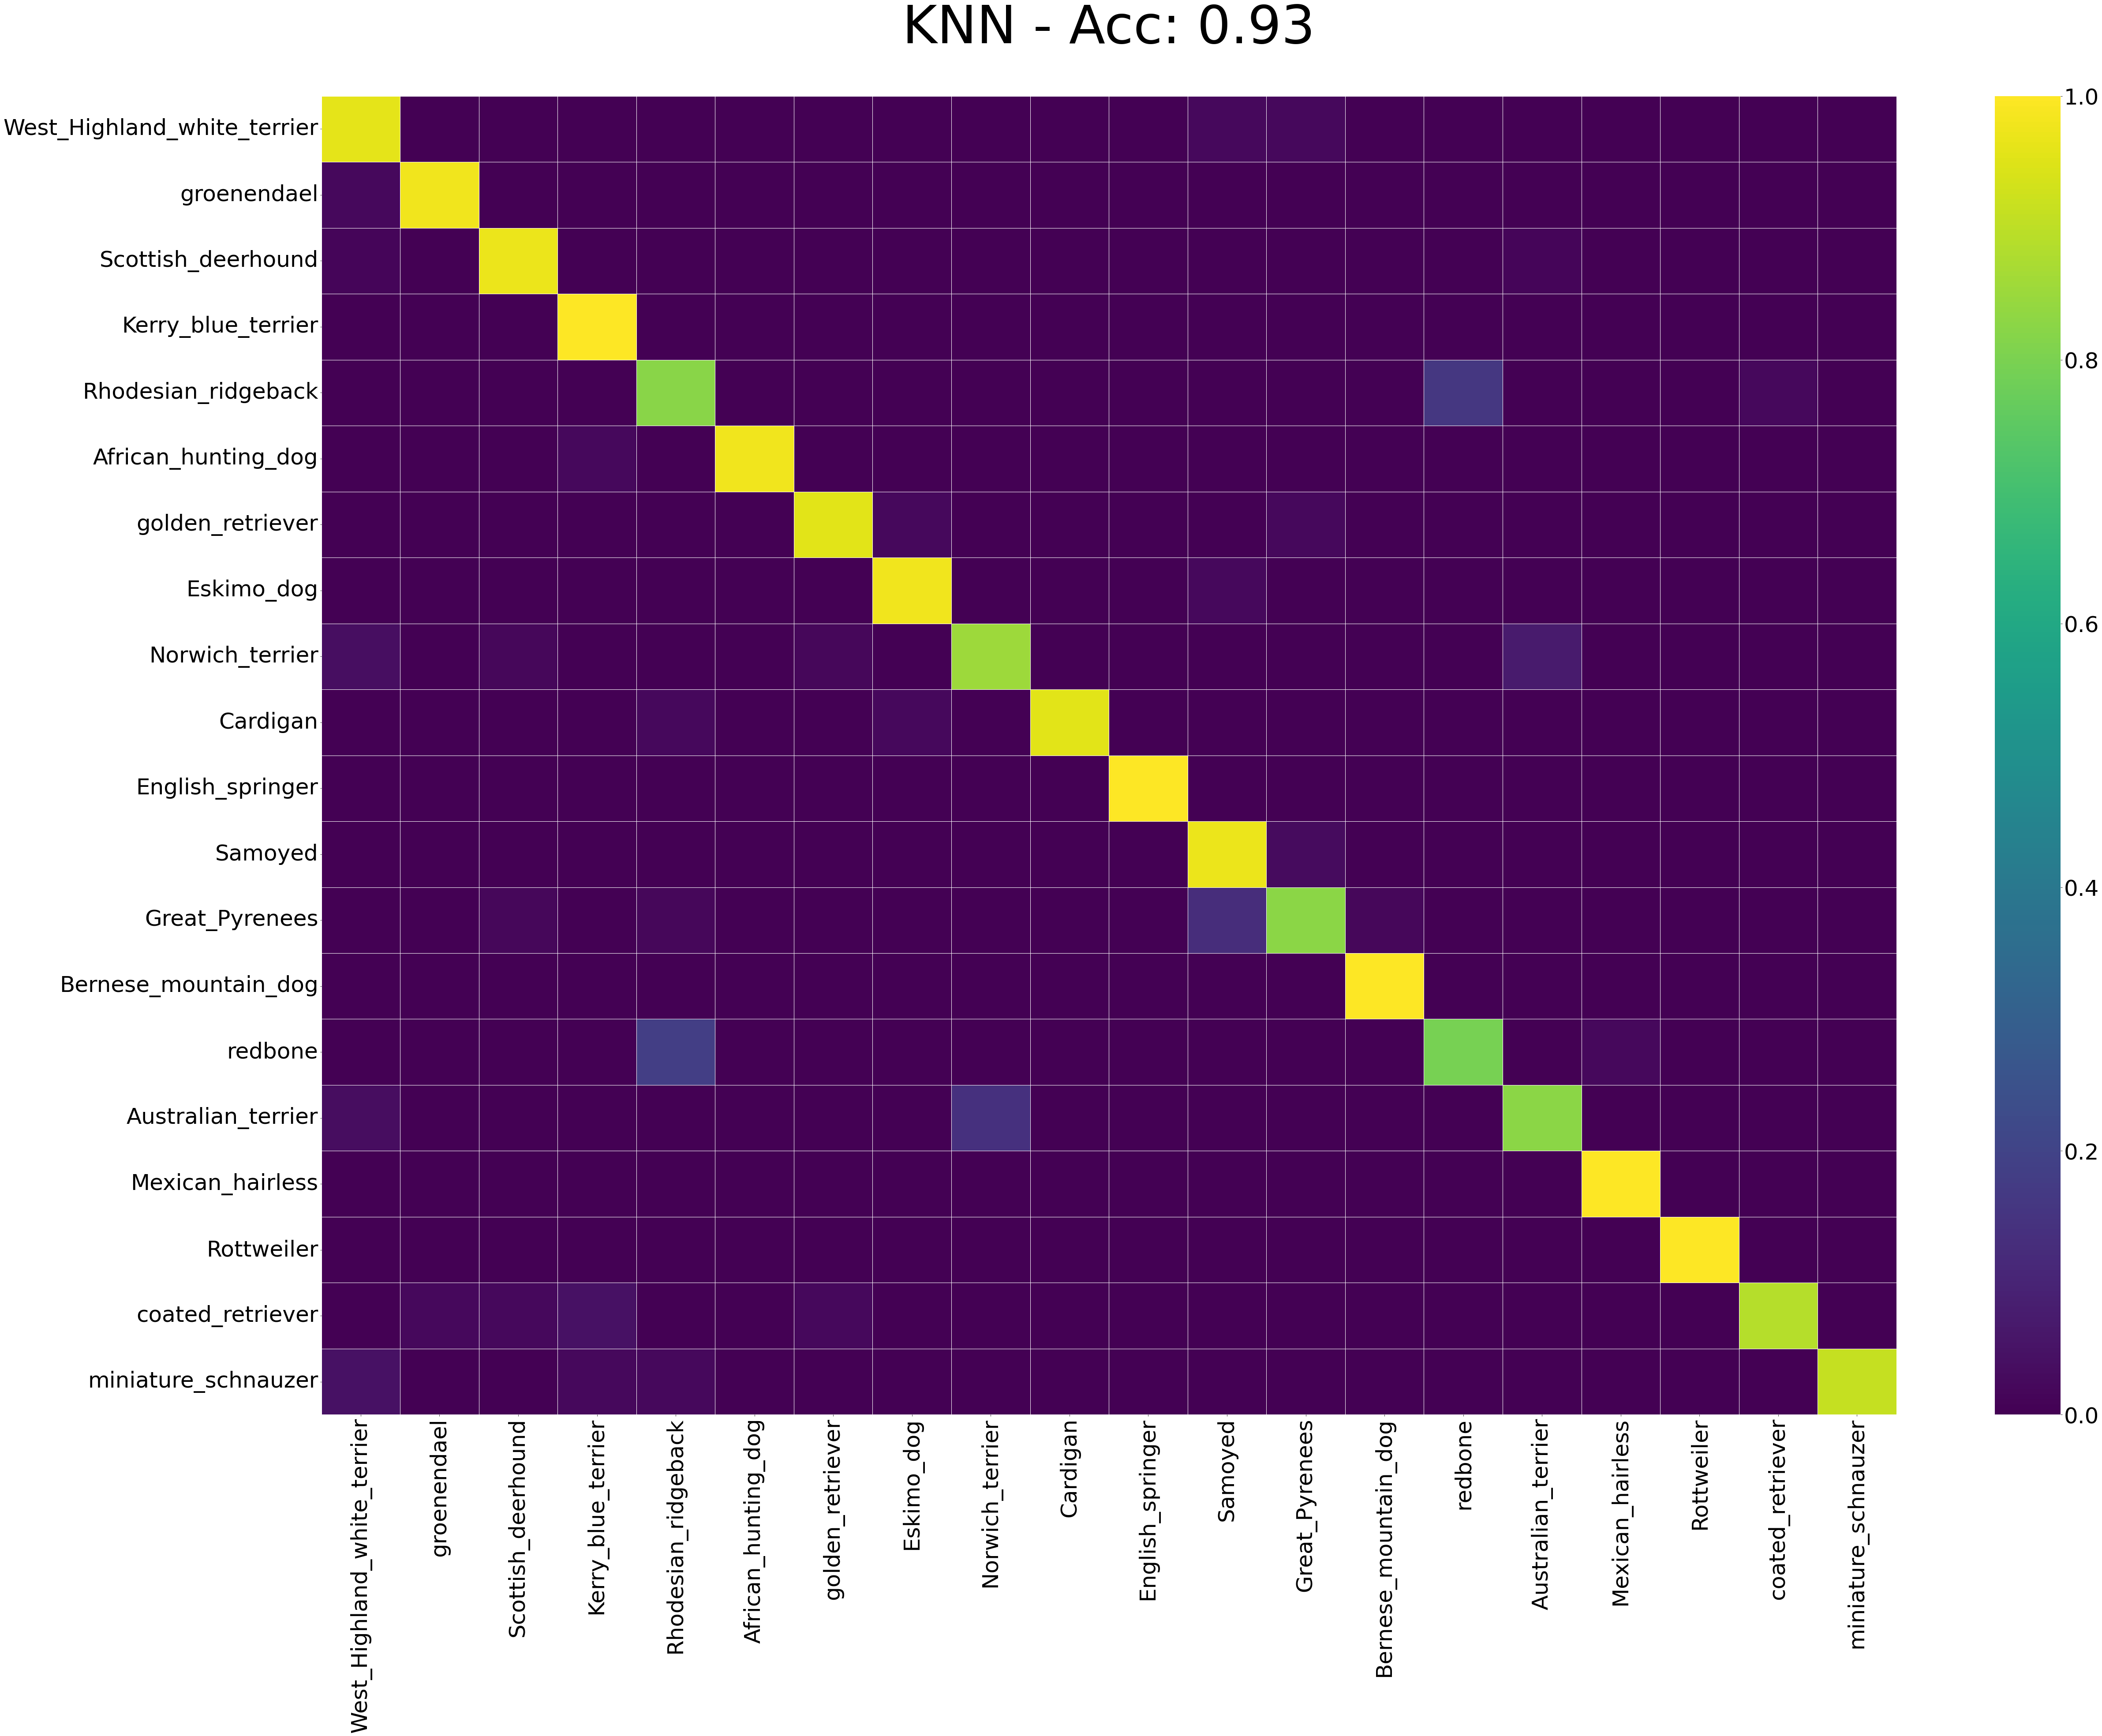

In [11]:
plot_title = f'KNN - Acc: {acc:.2f}'
save_img=False
path_img=None

cm = confusion_matrix(y_test, prediction, normalize='true')

plt.rcParams.update({'font.size': 50})

df_cm = pd.DataFrame(cm, index = [i for i in enroll_class_dict.keys()],
                     columns = [i for i in enroll_class_dict.keys()])

plt.figure(figsize = (80,55))

plt.title(plot_title, fontsize=120, pad=120)

sns.heatmap(df_cm, annot=False, linewidths=.5, cmap='viridis')

if save_img:
    sn_plot.savefig(path_img)

In [12]:
# KNN Report
cr = classification_report(y_test, prediction, target_names=enroll_class_dict.keys())
print(cr)

                             precision    recall  f1-score   support

West_Highland_white_terrier       0.86      0.96      0.91        50
                groenendael       0.98      0.98      0.98        44
         Scottish_deerhound       0.96      0.97      0.96        69
         Kerry_blue_terrier       0.93      1.00      0.96        53
        Rhodesian_ridgeback       0.79      0.82      0.81        51
        African_hunting_dog       1.00      0.98      0.99        50
           golden_retriever       0.95      0.95      0.95        44
                 Eskimo_dog       0.96      0.98      0.97        44
            Norwich_terrier       0.85      0.85      0.85        55
                   Cardigan       1.00      0.96      0.98        46
           English_springer       1.00      1.00      1.00        47
                    Samoyed       0.86      0.97      0.91        65
             Great_Pyrenees       0.93      0.83      0.87        63
       Bernese_mountain_dog      

# t-SNE - Visualizando Nossos Dados

Assim como mencionado na documentação do Sklearn, o t-SNE ([paper ref.](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf?fbclid=IwA) / [sklearn ref.](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)) é uma ferramenta que nos permite visualizar dados de alta dimensionalidade. A ferramenta converte semelhanças entre pontos de dados em probabilidades conjuntas e tenta minimizar a divergência de Kullback-Leibler entre as probabilidades conjuntas de incorporação de baixa dimensão e os dados de alta dimensão.

A minha ideia em propor essa visualização foi para que possamos analisar (visualmente) a **qualidade das features extraídas pelo nosso modelo**, a fim de receber um *feedback* visual do quão díficil é clusterizar os dados propostos pelo problema de *enroll*.

In [13]:
tsne = TSNE(n_components=2, random_state=0)

In [14]:
X_train_tsne = tsne.fit_transform(X_train)

A:\torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
A:\torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


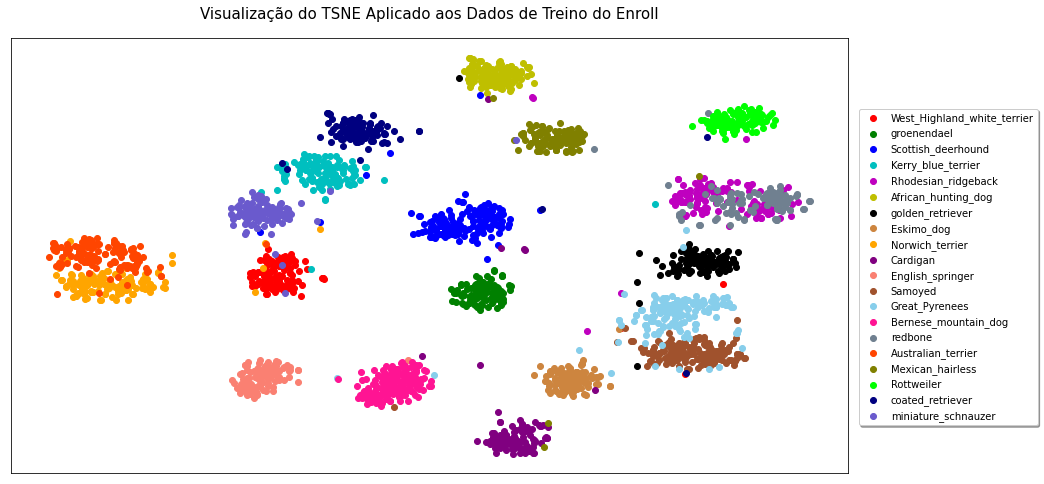

<Figure size 432x288 with 0 Axes>

In [20]:
target_ids = range(len(enroll_class_dict.keys()))

y = np.asarray(y_train)

plt.figure(figsize=(15, 8))
colors = ('r', 'g', 'b', 'c', 'm', 'y', 'k', 'peru', 'orange', 'purple', 'salmon', 
          'sienna', 'skyblue', 'deeppink', 'slategray', 'orangered', 'olive', 'lime', 'navy', 'slateblue')

for i, c, label in zip(target_ids, colors, enroll_class_dict.keys()):
    # print(label, c)
    plt.scatter(X_train_tsne[y == i, 0], X_train_tsne[y == i, 1], c=c, label=label)
    
plot_title = 'Visualização do TSNE Aplicado aos Dados de Treino do Enroll'
plt.title(plot_title, fontsize=15, pad=20)
plt.legend(loc='upper center', bbox_to_anchor=(1.12, 0.85),
          ncol=1, fancybox=True, shadow=True, prop={'size': 10})

#plt.axis('off')
plt.yticks([])
plt.xticks([])
plt.show()
img_path = './../reports/figures/train_enroll_tsne.png'
plt.savefig(img_path)

In [16]:
X_test_tsne = tsne.fit_transform(X_test)

A:\torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
A:\torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


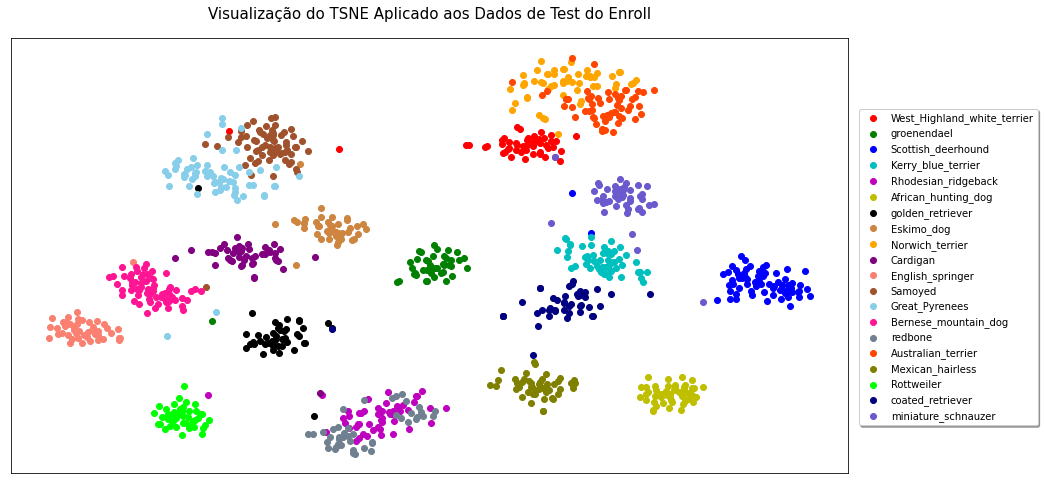

<Figure size 432x288 with 0 Axes>

In [21]:
target_ids = range(len(enroll_class_dict.keys()))

y = np.asarray(y_test)

plt.figure(figsize=(15, 8))
colors = ('r', 'g', 'b', 'c', 'm', 'y', 'k', 'peru', 'orange', 'purple', 'salmon', 
          'sienna', 'skyblue', 'deeppink', 'slategray', 'orangered', 'olive', 'lime', 'navy', 'slateblue')

for i, c, label in zip(target_ids, colors, enroll_class_dict.keys()):
    # print(label, c)
    plt.scatter(X_test_tsne[y == i, 0], X_test_tsne[y == i, 1], c=c, label=label)
    
plot_title = 'Visualização do TSNE Aplicado aos Dados de Test do Enroll'
plt.title(plot_title, fontsize=15, pad=20)
plt.legend(loc='upper center', bbox_to_anchor=(1.12, 0.85),
          ncol=1, fancybox=True, shadow=True, prop={'size': 10})

#plt.axis('off')
plt.yticks([])
plt.xticks([])
plt.show()
img_path = './../reports/figures/train_enroll_tsne.png'
plt.savefig(img_path)

Assim como na **Matriz de Confusão** apresentada anteriormente, o interessente dessa visualização é que podemos verificar alguns agrupamentos. O que me chamou a atenção foram os pares (**Rhodesian Ridgeback** / **Redbone**) e (**Great Pyrenees** / **Samoyed**).

Para fins de curiosidade e investigação, plotamos os pares abaixo para visualização.

In [22]:
enroll_dir = './../data/dogs/recognition/enroll/'
rhodesian_path = 'n02087394-Rhodesian_ridgeback/'
red_bone_path = 'n02090379-redbone/'
great_pyrenees_path = 'n02111500-Great_Pyrenees/'
samoyed_path = 'n02111889-Samoyed/'

*Obs: adaptei o código pra plotar imagens aleatórias das classes mencionadas toda vez que ele é executado. Podemos ver vários exemplos executando diversas vezes a célula abaixo.*

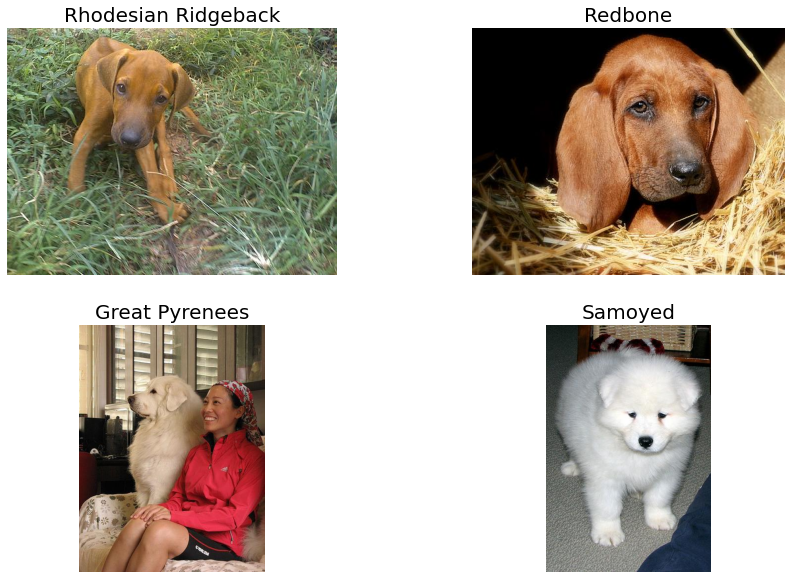

In [29]:
img_path_rhodesian = random.choice(os.listdir(enroll_dir+rhodesian_path))
img_rhodesian = Image.open(enroll_dir+rhodesian_path+img_path_rhodesian)
rhodesian_breed = 'Rhodesian Ridgeback'

img_path_red_bone = random.choice(os.listdir(enroll_dir+red_bone_path))
img_red_bone = Image.open(enroll_dir+red_bone_path+img_path_red_bone)
red_bone_breed = 'Redbone'

img_path_great_pyrenees = random.choice(os.listdir(enroll_dir+great_pyrenees_path))
img_great_pyrenees = Image.open(enroll_dir+great_pyrenees_path+img_path_great_pyrenees)
great_pyrenees_breed = 'Great Pyrenees'

img_path_samoyed = random.choice(os.listdir(enroll_dir+samoyed_path))
img_samoyed = Image.open(enroll_dir+samoyed_path+img_path_samoyed)
samoyed_breed = 'Samoyed'


fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_rhodesian)
ax1.set_title(rhodesian_breed, size=20)

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img_red_bone)
ax2.set_title(red_bone_breed, size=20)

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(img_great_pyrenees)
ax3.set_title(great_pyrenees_breed, size=20)

ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img_samoyed)
ax4.set_title(samoyed_breed, size=20)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

E o resultado da investigação é impressionante (haha). Realmente as classes dividem várias semelhanças o que pode nos levar a pensar que para aumentar a qualidade da nossa classificação devemos pensar em modelos capazes de aprender ainda mais características do problema. Podemos treinar mais camadas da nossa rede pré-treinada, podemos optar por usar outra arquitetura (ResNet101, EfficientNet, etc), como podemos trabalhar em extrair features específicas com alguma técnica de *handcrafted*, entre outras ideias.

---

# Início do problema de Unknown

## Terceira Parte

Além disso, considere o que acontece se uma raça previamente não vista, e nem cadastrada, é fornecida ao sistema. Como o sistema pode agir para identificar que essa raça não existe no banco de dados? Ou seja, se o cliente passar uma foto de um Golden Retriever cuja raça não foi cadastrada no processo de enroll, o sistema deve informar que essa não é uma raça cadastrada. Esse é o problema de *unknowns*.

## Ideia 1 - Threshold pela distância do KNN

Iniciei tentando resolver a **Terceira Parte** do problema coletando as distâncias das features de teste do enroll e validação, 100 classes, **classes as quais não fazem parte do "treinamento" do KNN**. A ideia era verificar a distribuição dessas features focada no vizinho mais próximo a elas. O problema dessa abordagem é que apesar dos dados serem diferentes, existe muito sobreposição nas distâncias. O que torna a criação de uma abordagem via **threshold** muito mais complicada.

In [30]:
nearest = []

for x in tqdm(X_test):
    result = neigh.kneighbors([x])
    nearest.append(result[0][0][0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1030/1030 [00:07<00:00, 129.97it/s]


In [31]:
print(f'Max: {np.max(nearest):.2f}, Min: {np.min(nearest):.2f}, Mean: {np.mean(nearest):.2f}, Std: {np.std(nearest):.2f}')

Max: 82.18, Min: 0.00, Mean: 40.24, Std: 9.57


In [32]:
nearest_val = []

for x in tqdm(X_dog_val):
    result = neigh.kneighbors([x])
    nearest_val.append(result[0][0][0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3420/3420 [00:26<00:00, 128.61it/s]


In [33]:
print(f'Max: {np.max(nearest_val):.2f}, Min: {np.min(nearest_val):.2f}, Mean: {np.mean(nearest_val):.2f}, Std: {np.std(nearest_val):.2f}')

Max: 79.69, Min: 0.00, Mean: 50.91, Std: 7.61


In [38]:
# voltando a config padrão
plt.rcParams.update({'font.size': 15})

### Análise dos dados mencionados anteriormente (0 = Enroll, 1 = Validação (100 Classes))

1030
3420


<AxesSubplot:ylabel='Count'>

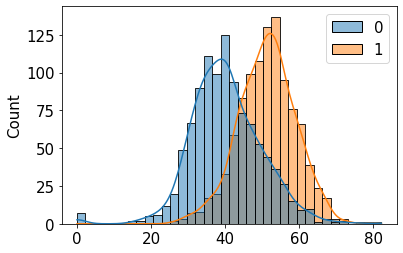

In [39]:
print(len(nearest))
print(len(nearest_val))

sns.histplot(data=[nearest, nearest_val[:1030]], kde=True)

## Ideia 2 - Threshold pela distância do K-Means

---

A segunda ideia para resolver a **Terceira Etapa** do problema, não se diferencia muito da primeira, pois ao invés do KNN, buscamos extrair as distâncias do algoritmo de agrupamento K-Means. Inicializei o algoritmo definindo o número de classes já conhecido no enroll (20), e analisei a distribuição dos dados de Enroll e Not-Enroll. E o resultado também não foi muito animador.

In [43]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(X_train)

In [44]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [49]:
kmeans_nearest_test = []
kmeans_nearest_val = []

for x in tqdm(X_test):
    result = np.min(kmeans.transform([x]))
    kmeans_nearest_test.append(result)

for x in tqdm(X_dog_val):
    result = np.min(kmeans.transform([x]))
    kmeans_nearest_val.append(result)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3420/3420 [00:01<00:00, 2782.81it/s]


In [50]:
print(np.mean(kmeans_nearest_test))
print(np.std(kmeans_nearest_test))

43.08297347590089
10.224890281001302


In [51]:
print(np.mean(kmeans_nearest_val))
print(np.std(kmeans_nearest_val))

53.744655633120075
8.35431096363582


<AxesSubplot:ylabel='Count'>

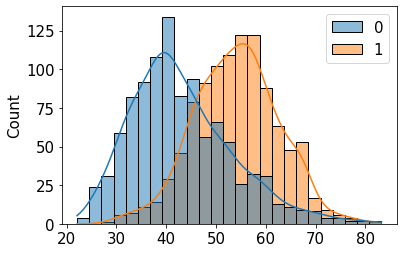

In [52]:
sns.histplot(data=[kmeans_nearest_test, kmeans_nearest_val[:1030]], kde=True)

## Ideia 3 - Treinar um KNN para identificar **Enroll** ou **Unknown**

Para essa tarefa, criei labels para as features extraídas mencionadas anteriormente (test enroll e validation (not enroll)) e dividi as features em treino/test, já que não irei tunar ou buscar outro modelo após esse. Com isso, executei um novo KNN para classificar **Enroll** ou **Unknown**.

In [53]:
enroll_class = np.zeros(len(y_train))
unknown_class = np.ones(len(y_train))

In [54]:
X_dog_val_train = X_dog_val[:2444]
X_dog_val_test = X_dog_val[2444:]

In [55]:
X_binary_train = []


for x in X_train:
    X_binary_train.append(x)

for x in X_dog_val_train:
     X_binary_train.append(x)

In [56]:
print(len(X_binary_train))
y_binary_train = []
y_binary_train.extend(enroll_class)
y_binary_train.extend(unknown_class)
print(len(y_binary_train))

4888
4888


In [58]:
binary_knn = KNeighborsClassifier(n_neighbors=3)
binary_knn.fit(X_binary_train, y_binary_train)

KNeighborsClassifier(n_neighbors=3)

In [59]:
len(X_dog_val_test)

976

In [60]:
X_binary_test = X_test[:976]

for x in X_dog_val_test:
    X_binary_test.append(x)

In [61]:
len(X_binary_test[:976])

976

In [62]:
y_dog_val_test = list(np.zeros(976))
y_dog_val_test.extend(np.ones(976))

In [63]:
prediction = binary_knn.predict(X_binary_test)

## Acurácia do modelo proposto

In [64]:
accuracy_score(y_dog_val_test, prediction)

0.8939549180327869

## Verificação com o t-SNE o quanto o modelo novo consegue agrupar os dados para classificação do Enroll x Unknown

In [65]:
tsne = TSNE(n_components=2, random_state=1)
X_train_tsne = tsne.fit_transform(X_binary_train)

labels = ['enroll', 'unknown']

A:\torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
A:\torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


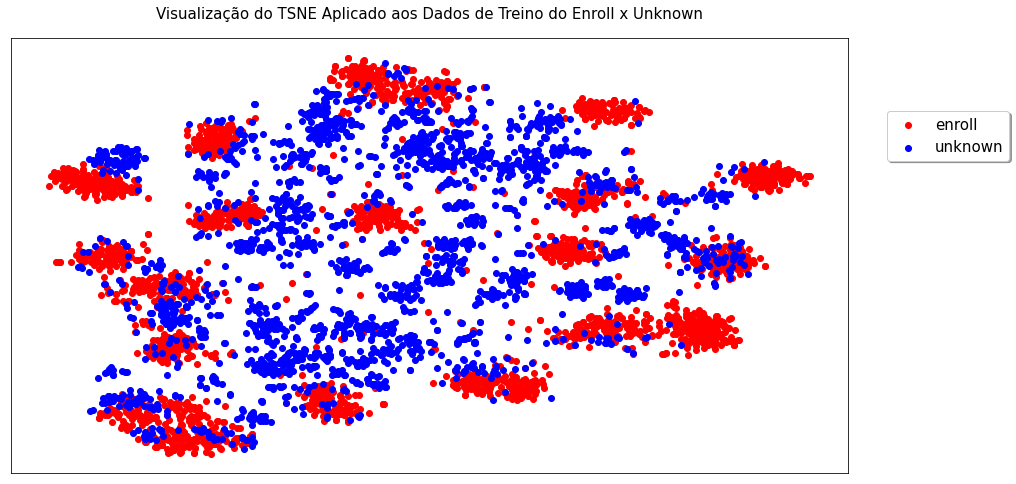

<Figure size 432x288 with 0 Axes>

In [66]:
target_ids = range(0,2)

y = np.asarray(y_binary_train)

plt.figure(figsize=(15, 8))
colors = ('r', 'b')

for i, c, label in zip(target_ids, colors, labels):
    plt.scatter(X_train_tsne[y == i, 0], X_train_tsne[y == i, 1], c=c, label=label)
    
plot_title = 'Visualização do TSNE Aplicado aos Dados de Treino do Enroll x Unknown'
plt.title(plot_title, fontsize=15, pad=20)
plt.legend(loc='upper center', bbox_to_anchor=(1.12, 0.85),
          ncol=1, fancybox=True, shadow=True)

#plt.axis('off')
plt.yticks([])
plt.xticks([])
plt.show()
img_path = './../reports/figures/binary_knn_train_tsne.png'
plt.savefig(img_path)

## Podemos verificar grupos de classes Enroll e Unknown, o que facilita a classificação para o KNN.

A:\torch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
A:\torch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


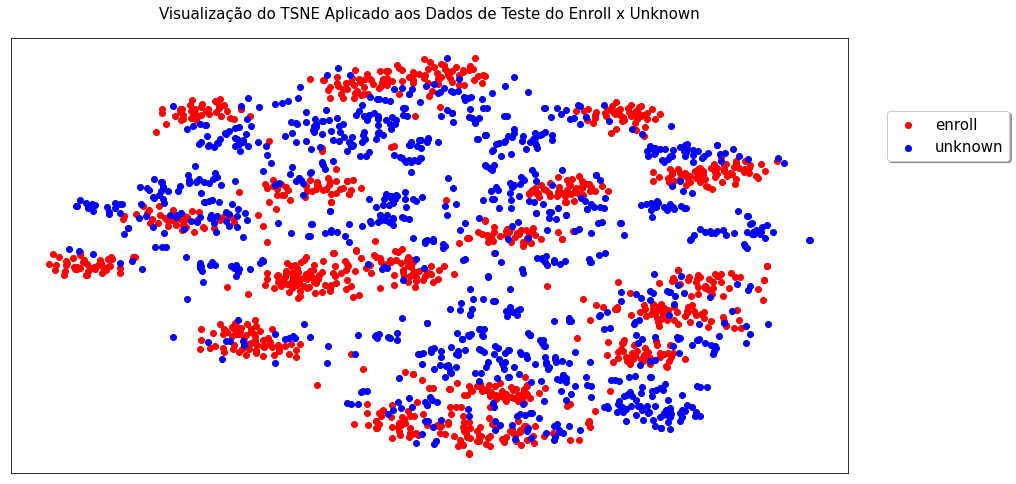

<Figure size 432x288 with 0 Axes>

In [67]:
X_binary_test_tsne = tsne.fit_transform(X_binary_test)
labels = ['enroll', 'unknown']

target_ids = range(0,2)

y = np.asarray(y_dog_val_test)

plt.figure(figsize=(15, 8))
colors = ('r', 'b')

for i, c, label in zip(target_ids, colors, labels):
    plt.scatter(X_binary_test_tsne[y == i, 0], X_binary_test_tsne[y == i, 1], c=c, label=label)
    
plot_title = 'Visualização do TSNE Aplicado aos Dados de Teste do Enroll x Unknown'
plt.title(plot_title, fontsize=15, pad=20)
plt.legend(loc='upper center', bbox_to_anchor=(1.12, 0.85),
          ncol=1, fancybox=True, shadow=True)

#plt.axis('off')
plt.yticks([])
plt.xticks([])
plt.show()
img_path = './../reports/figures/binary_knn_test_tsne.png'
plt.savefig(img_path)

## Salvando os modelos para o app ([Sklearn ref.](https://scikit-learn.org/stable/modules/model_persistence.html))

In [68]:
from joblib import dump, load

In [69]:
directory_breed = './../models/knn-breed/'
if not os.path.exists(directory_breed):
    os.makedirs(directory_breed)
    
directory_unknown = './../models/knn-unknown/'
if not os.path.exists(directory_unknown):
    os.makedirs(directory_unknown)

In [70]:
dump(neigh, directory_breed+'knn_breed.joblib') 

['./../models/knn-breed/knn_breed.joblib']

In [71]:
dump(binary_knn, directory_unknown+'knn_unknown.joblib') 

['./../models/knn-unknown/knn_unknown.joblib']